In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def generate_synthetic_data(n_samples=1000):
    np.random.seed(42)

    # Ana özellikler
    feature_0 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_1 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_2 = np.random.uniform(low=-2, high=2, size=n_samples)
    feature_3 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_4 = np.random.normal(loc=0, scale=1, size=n_samples)

    # Hedef değişkeni oluştur (çeşitli gizli etkileşimlerle ve koşullu durumlarla)
    target = (
        
        0.5
        * np.where(
            feature_0 > 0, feature_1, -feature_1
        )  # Koşullu etkileşim: feature_1 > 0 olunca feature_2 pozitif etkiliyor, aksi halde negatif
        + 0.3
        * np.maximum(
            feature_1, feature_2
        )  # En büyük olan feature'ı seçip pozitif etki veriyoruz
        + 0.6 * (feature_3) ** 2
        + 0.3 * np.sin(feature_3) * np.sin(feature_4)  # Sinüs ve kosinüs çarpımı
        + np.random.normal(loc=0, scale=0.1, size=n_samples)  # Gürültü ekleyelim
    )

    # Hedef değişkeni ikili sınıflandırma için dönüştür
    target_binary = (target > target.mean()).astype(int)

    # DataFrame oluştur
    df = pd.DataFrame(
        {
            "feature_0": feature_0,
            "feature_1": feature_1,
            "feature_2": feature_2,
            "feature_3": feature_3,
            "feature_4": feature_4,
            "target": target_binary,
        }
    )

    return df


# Veri setini oluştur
df = generate_synthetic_data(n_samples=10000)

# Eğitim ve test setlerine ayır
X = df.drop("target", axis=1).values
y = df["target"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "max_depth": 4,
    "feature_fraction": 0.9,
}

# Train the model
num_round = 100
model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 3318, number of negative: 4682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.414750 -> initscore=-0.344363
[LightGBM] [Info] Start training from score -0.344363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [11]:
from tree_explainer import Explainer, plot_interaction

In [12]:
tree = Explainer()
tree(model)

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)
shap_interaction_values = explainer.shap_interaction_values(X_train)

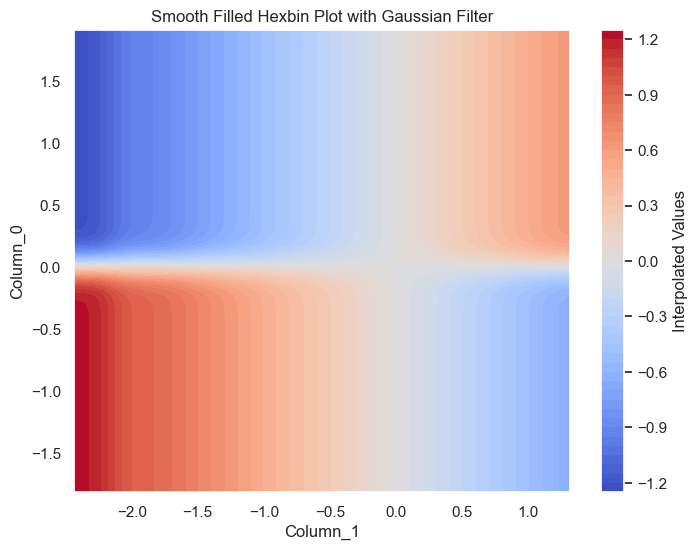

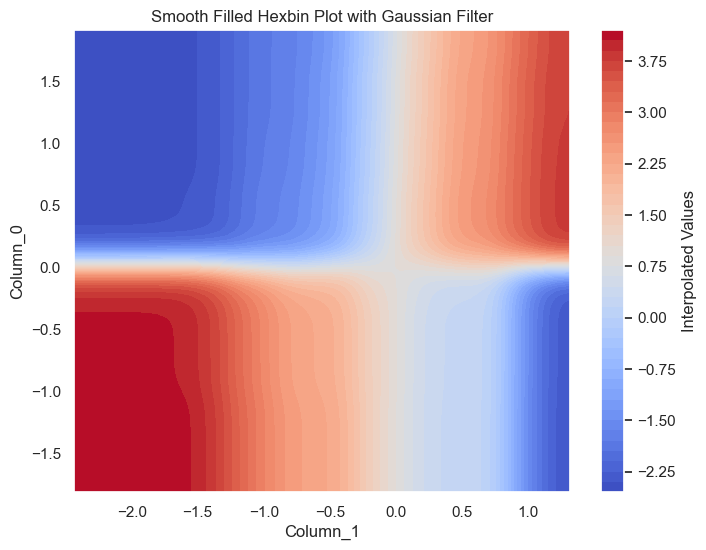

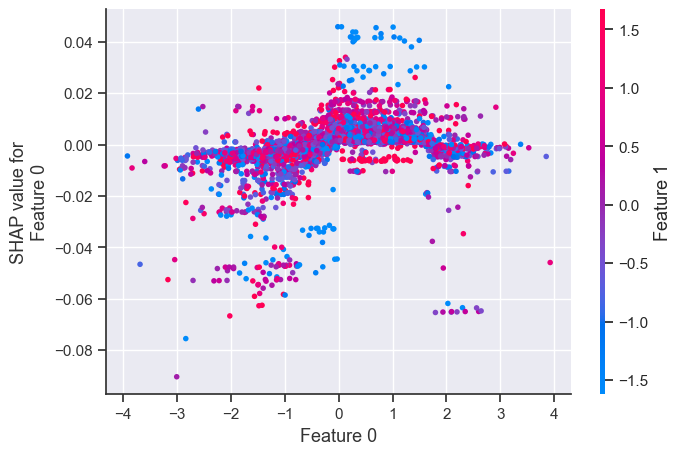

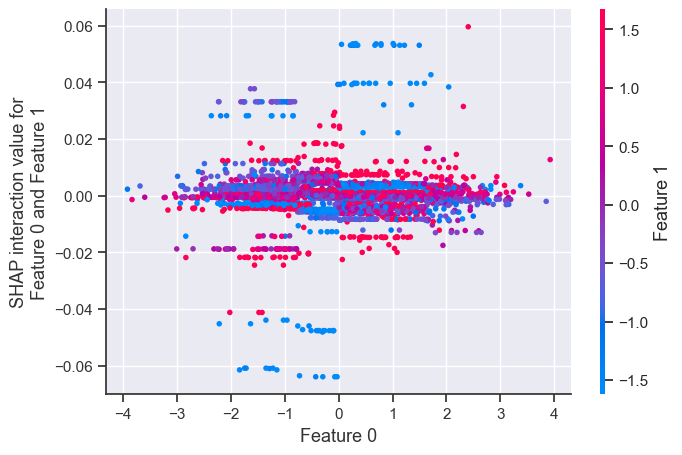

In [13]:
df = tree.analyze_dependency(0, 1)

df_original = df.copy()
df_original["values"] = 0.5 * np.where(
    df_original["Column_0"] > 0, df_original["Column_1"], -df_original["Column_1"]
)


plot_interaction(df_original)
plot_interaction(df)

shap.dependence_plot(0, shap_values.values, X_train, interaction_index=1)

shap.dependence_plot((0, 1), shap_interaction_values, X_train, display_features=X_train)

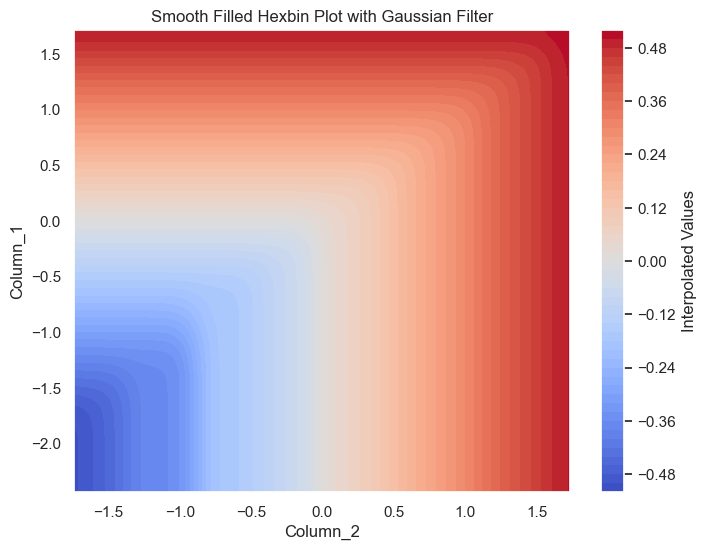

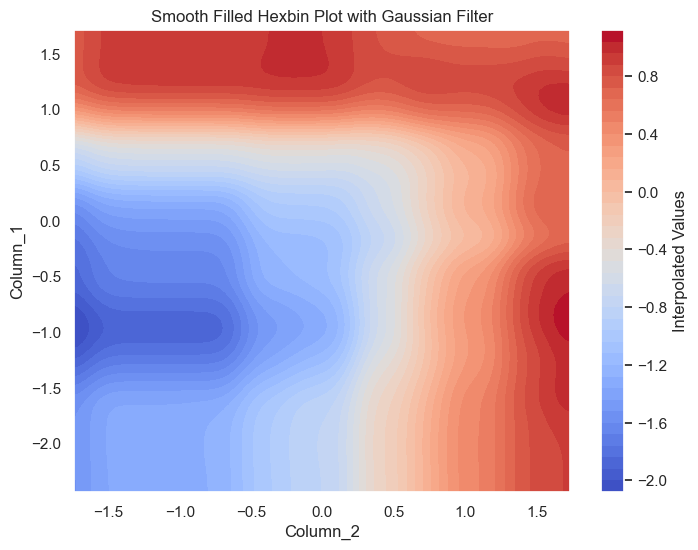

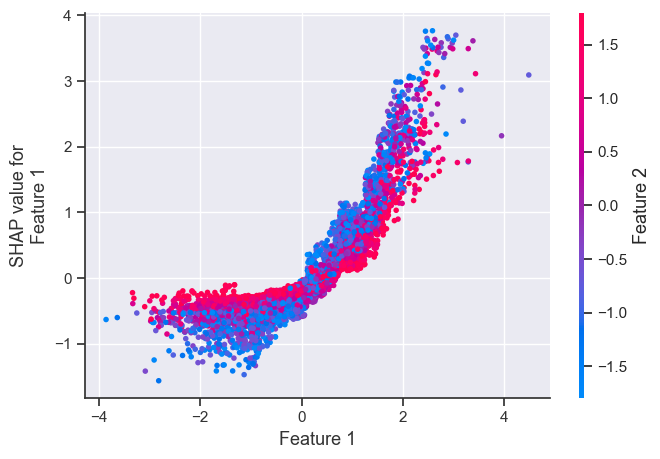

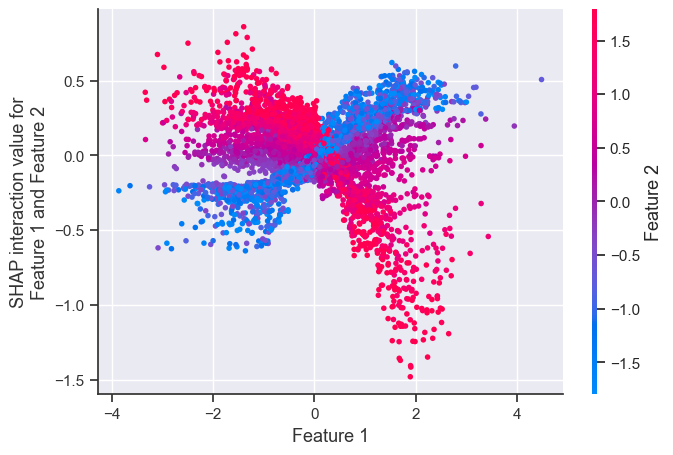

In [15]:
df = tree.analyze_dependency(1, 2)

df_original = df.copy()

df_original["values"] = 0.3 * np.maximum(
    df_original["Column_1"], df_original["Column_2"]
)

plot_interaction(df_original)
plot_interaction(df)

shap.dependence_plot(1, shap_values.values, X_train, interaction_index=2)

shap.dependence_plot((1, 2), shap_interaction_values, X_train, display_features=X_train)

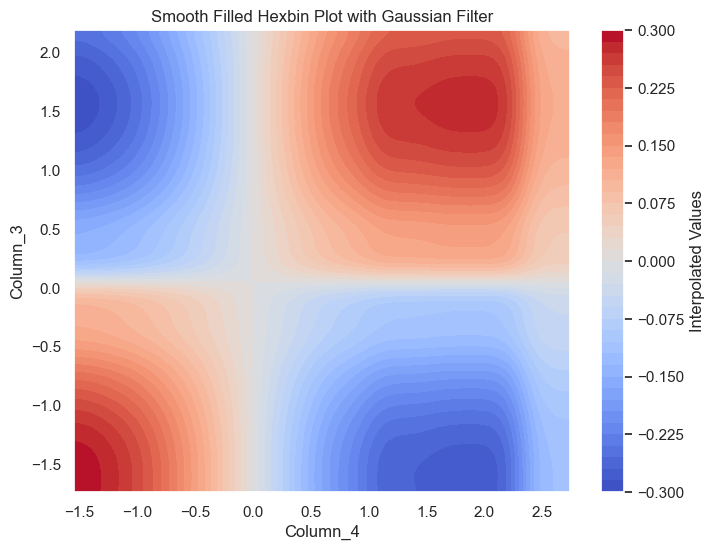

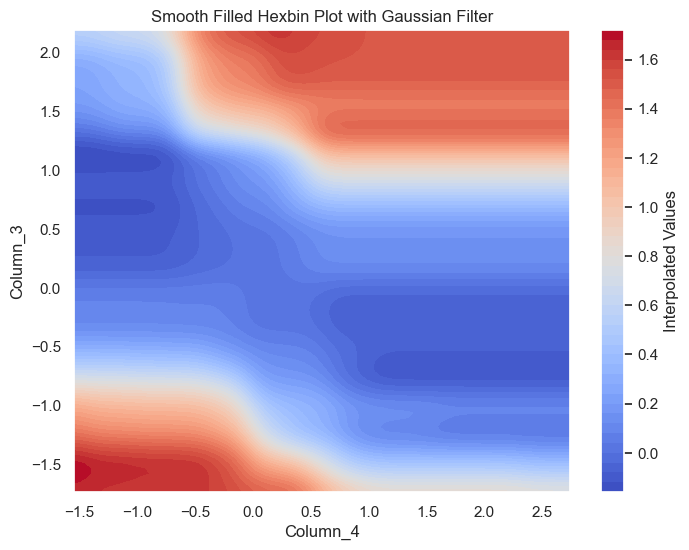

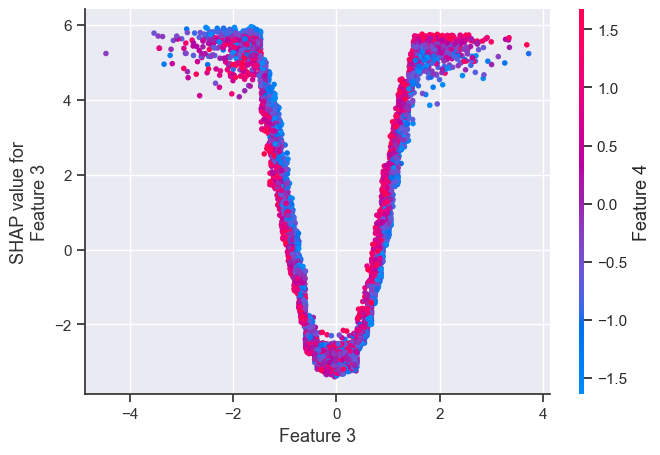

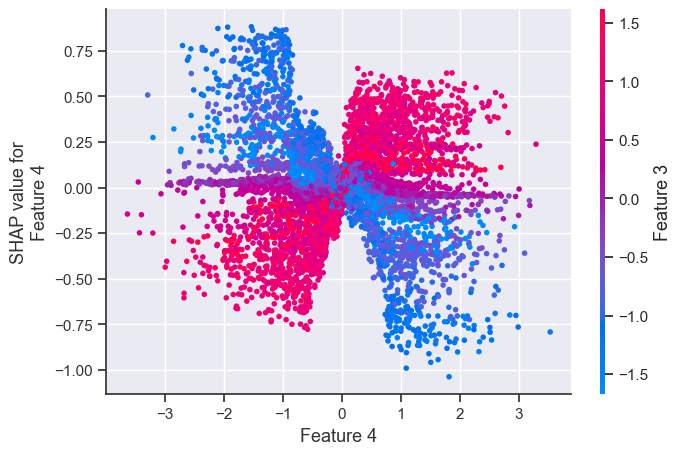

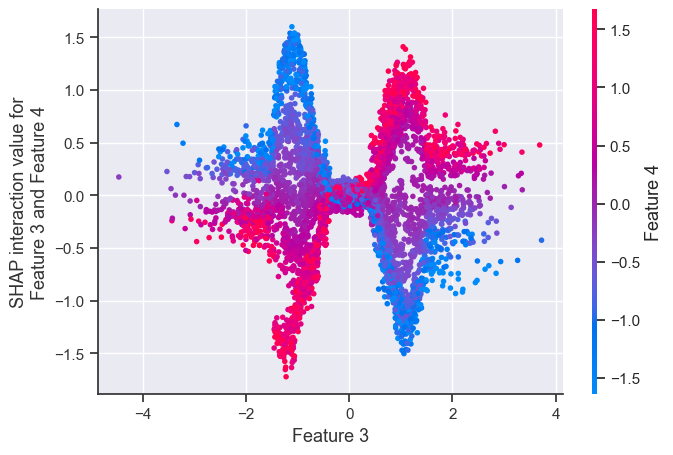

In [20]:
df = tree.analyze_dependency(3, 4)

df_original = df.copy()
df_original["values"] = 0.3 * np.sin(df_original["Column_3"]) * np.sin(df_original["Column_4"])

plot_interaction(df_original)
plot_interaction(df)

shap.dependence_plot(3, shap_values.values, X_train, interaction_index=4)

shap.dependence_plot(4, shap_values.values, X_train, interaction_index=3)


shap.dependence_plot((3, 4), shap_interaction_values, X_train, display_features=X_train)

